# Compilation methods for Hamiltonian simulation circuits
Estimated QPU usage: no execution was done in this tutorial because it is focused on the transpilation process.

{/* cspell:ignore Rustiq, nshuffles, edgecolor, Hamlib, Benchpress, Brugière, Goubault, Martiel, Dubal, Lishman, Ivrii, fontweight, fontsize, textprops, wedgeprops, startangle, autopct */}

## Background

Quantum circuit compilation is a crucial step in the quantum computing workflow. It involves transforming a high-level quantum algorithm into a physical quantum circuit that adheres to the constraints of the target quantum hardware. Effective compilation can significantly impact the performance of quantum algorithms by reducing circuit depth, gate count, and execution time. This tutorial explores three distinct approaches to quantum circuit compilation in Qiskit, showcasing their strengths and applications through practical examples.

The goal of this tutorial is to enable users to understand and utilize these compilation methods: the transpilation with the SABRE algorithm, the AI-powered transpiler, and the Rustiq plugin. By comparing these methods across different quantum circuits, users will gain insights into how to optimize their circuits for specific goals, such as minimizing depth or gate count.

### What you will learn
- **How to use the Qiskit transpiler with SABRE for layout and routing optimization.**
- **How to leverage the AI transpiler for advanced, automated circuit optimization.**
- **How to employ the Rustiq plugin for circuits requiring precise synthesis of operations, particularly in Hamiltonian simulation tasks.**

This tutorial uses three example circuits generated with Qiskit’s patterns module to illustrate the performance of each compilation method. By the end of this tutorial, users will be equipped to choose the appropriate compilation strategy based on their specific requirements and constraints.

### Compilation methods overview

#### 1. **Qiskit transpiler with SABRE**
The Qiskit transpiler uses the SABRE (SWAP-based BidiREctional heuristic search) algorithm to optimize circuit layout and routing. SABRE focuses on minimizing SWAP gates and their impact on circuit depth while adhering to hardware connectivity constraints. This method is highly versatile and suitable for general-purpose circuit optimization, providing a balance between performance and computation time. To take advantage of the latest improvements in SABRE, detailed in [\[1\]](https://arxiv.org/abs/2409.08368), you can increase the number of trials (for example, `layout_trials=400, swap_trials=400`). For the purposes of this tutorial, we will use the default values for the number of trials in order to compare to Qiskit's default transpiler. The advantages and parameter exploration of SABRE are covered in a separate deep-dive tutorial.

#### 2. **AI Transpiler**

The AI-powered transpiler in Qiskit uses machine learning to predict optimal transpilation strategies by analyzing patterns in circuit structure and hardware constraints to select the best sequence of optimizations for a given input. This method is particularly effective for large-scale quantum circuits, offering a high degree of automation and adaptability to diverse problem types. In addition to general circuit optimization, the AI transpiler can be used with the `AIPauliNetworkSynthesis` pass, which targets Pauli Network circuits—blocks composed of H, S, SX, CX, RX, RY, and RZ gates—and applies a reinforcement learning-based synthesis approach. This pass is currently only available through the Qiskit Transpiler Service and supports up to six-qubit blocks. For more information on the AI transpiler and its synthesis strategies, see [\[2\]](https://arxiv.org/abs/2405.13196) and [\[3\]](https://arxiv.org/abs/2503.14448).



#### 3. **Rustiq Plugin**
The Rustiq plugin introduces advanced synthesis techniques specifically for `PauliEvolutionGate` operations, which represent Pauli rotations commonly used in Trotterized dynamics. This plugin is valuable for circuits implementing Hamiltonian simulation, such as those used in quantum chemistry and physics problems, where accurate Pauli rotations are essential for simulating problem Hamiltonians effectively. Rustiq offers precise, low-depth circuit synthesis for these specialized operations. For more details about the implementation and performance of Rustiq, please refer to [\[4\]](https://arxiv.org/abs/2404.03280).

---

By exploring these compilation methods in depth, this tutorial provides users with the tools to enhance the performance of their quantum circuits, paving the way for more efficient and practical quantum computations.

## Requirements

Before starting this tutorial, be sure you have the following installed:
- Qiskit SDK v1.3 or later ( `pip install 'qiskit[visualization]'` )
- Qiskit Runtime 0.28 or later (`pip install qiskit-ibm-runtime`)
- Qiskit IBM Transpiler (`pip install qiskit-ibm-transpiler`)
- Qiskit AI Transpiler local mode (`pip install qiskit_ibm_ai_local_transpiler`)
- Networkx graph library (`pip install networkx`)

## Setup

In [29]:
from qiskit.circuit import QuantumCircuit, Measure
from qiskit.dagcircuit import DAGInNode, DAGOpNode
from qiskit.transpiler import PassManager, TransformationPass
from qiskit_ibm_runtime import QiskitRuntimeService
from qiskit.transpiler.passes import BasisTranslator
from qiskit.circuit.library import (
    EfficientSU2,
    PauliEvolutionGate,
    RZGate,
    ZGate,
    SGate,
    SdgGate,
)
from qiskit.circuit.library.standard_gates.equivalence_library import (
    StandardEquivalenceLibrary as std_eqlib,
)
from qiskit_ibm_transpiler import generate_ai_pass_manager
from qiskit_ibm_transpiler.ai.synthesis import AIPauliNetworkSynthesis
from qiskit_ibm_transpiler.ai.collection import CollectPauliNetworks
from qiskit_ibm_transpiler.ai.routing import AIRouting
from qiskit.transpiler.passes import Optimize1qGates
from qiskit.quantum_info import SparsePauliOp
from qiskit.transpiler.preset_passmanagers import generate_preset_pass_manager
from qiskit.transpiler.passes.synthesis.high_level_synthesis import HLSConfig
from collections import Counter
from IPython.display import display
import time
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import json
import logging

logging.disable(logging.CRITICAL)

seed = 42  # Seed for reproducibility

# Part 1: EfficientSU2 Circuit

## Step 1: Map classical inputs to a quantum problem

In this section, we explore the `EfficientSU2` circuit, a hardware-efficient ansatz commonly used in variational quantum algorithms (e.g., VQE) and quantum machine learning tasks. The circuit consists of alternating layers of single-qubit rotations and entangling gates arranged in a circular pattern, designed to explore the quantum state space effectively while maintaining manageable depth.

We will begin by constructing one `EfficientSU2` circuit to demonstrate how to compare different compilation methods. After Part 1, we will expand our analysis to a larger set of circuits, enabling a comprehensive benchmark for evaluating the performance of various compilation techniques.

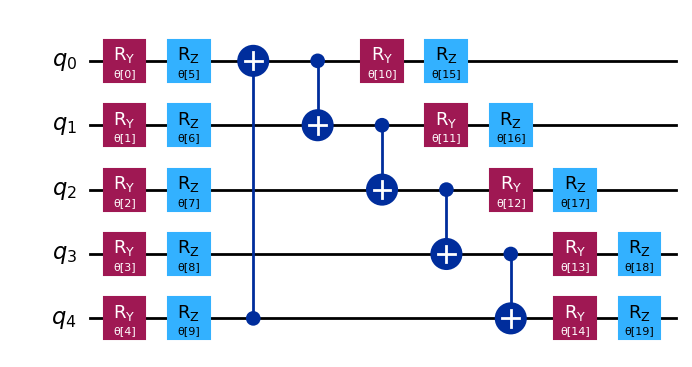

In [2]:
qubit_size = [
    5,
    10,
    15,
    20,
    25,
    30,
    35,
    40,
    45,
    50,
    55,
    60,
    65,
    70,
    75,
    80,
    85,
    90,
    95,
    100,
]
qc_su2_list = [
    EfficientSU2(n, entanglement="circular", reps=1).decompose().copy(name=f"SU2_{n}")
    for n in qubit_size
]

# Draw the first circuit
qc_su2_list[0].draw(output="mpl", fold=-1)

## Step 2: Optimize problem for quantum hardware execution

This step is the main focus of the notebook. Here, we aim to optimize the Hamiltonian simulation circuit for execution on quantum hardware. First, we select a backend with at least 127 qubits to ensure sufficient resources for running the circuit. Next, we create three separate pass managers, each implementing one of the transpilation methods: the Qiskit transpiler with SABRE, the AI-powered transpiler, and the Rustiq plugin.

The goal of this step is to compare the results of these three methods in terms of the transpiled circuit's depth and gate count. Another important metric we will consider is the time taken to perform the transpilation. By analyzing these metrics, we can determine which method produces the most efficient circuit for execution on the selected hardware.

In [3]:
# QiskitRuntimeService.save_account(channel="ibm_quantum", token="<MY_IBM_QUANTUM_TOKEN>", overwrite=True, set_as_default=True)
service = QiskitRuntimeService(channel="ibm_quantum")
backend = service.backend("ibm_torino")
print(f"Using backend: {backend}")

Using backend: <IBMBackend('ibm_torino')>


In order to compare apples to apples, we need to make sure that the transpiled circuit for each method has the same basis gates, so that we can accurately compare the depth and gate count. To simplify this, we will set all of the basis gates to use the basis set of ['u', 'cx'].

In [4]:
basis_gates = ["u", "cx"]

Qiskit Transpiler with SABRE

In [5]:
pm_sabre = generate_preset_pass_manager(
    optimization_level=3, backend=backend, seed_transpiler=seed, basis_gates=basis_gates
)

/var/folders/jt/44gl1rhd26v6ykt0frqzl87r0000gn/T/ipykernel_59246/682414580.py:1: UserWarning: Providing `coupling_map` and/or `basis_gates` along with `backend` is not recommended, as this will invalidate the backend's gate durations and error rates.
  pm_sabre = generate_preset_pass_manager(optimization_level=3, backend=backend, seed_transpiler=seed, basis_gates=basis_gates)


AI Transpiler

In [ ]:
# Standard AI transpiler routing pass using local mode and built off from the preset pass
# manager, which is much faster than server mode
ai_routing = AIRouting(
    backend=backend, optimization_level=3, layout_mode="optimize", local_mode=True
)

pm_ai = generate_ai_pass_manager(
    backend=backend,
    optimization_level=3,
    ai_optimization_level=3,
    include_ai_synthesis=False,
    ai_layout_mode="optimize",
    qiskit_transpile_options={"basis_gates": ["u", "cx"]},
)

/Users/henryzou/.venvs/rustiq-update/lib/python3.11/site-packages/qiskit_ibm_transpiler/ai_passmanager.py:55: UserWarning: Providing `coupling_map` and/or `basis_gates` along with `backend` is not recommended, as this will invalidate the backend's gate durations and error rates.
  pass_manager = generate_preset_pass_manager(


In [7]:
# Using the AI transpiler with Pauli network synthesis, only available in server mode
pm_ai_pauli = generate_ai_pass_manager(
    backend=backend,
    optimization_level=3,
    ai_optimization_level=3,
    include_ai_synthesis=False,
    ai_layout_mode="optimize",
    qiskit_transpile_options={
        "basis_gates": ["h", "s", "sdg", "rz", "sx", "sxdg", "x", "y", "z", "cx"]
    },
)


class RemoveInitialFinalRZs(TransformationPass):
    """Remove diagonal gates in beginning or before measurement (to reduce trivial non-cliffords)"""

    def run(self, dag):
        nodes_to_remove = set()
        for measure_node in dag.op_nodes(Measure):
            predecessor = next(dag.quantum_predecessors(measure_node))
            if isinstance(predecessor, DAGOpNode) and isinstance(
                predecessor.op, RZGate
            ):
                nodes_to_remove.add(predecessor)
        for rz_node in dag.op_nodes(RZGate):
            predecessor = next(dag.predecessors(rz_node))
            if isinstance(predecessor, DAGInNode):
                nodes_to_remove.add(rz_node)
        for node_to_remove in nodes_to_remove:
            dag.remove_op_node(node_to_remove)

        return dag


class CliffordizeRZs(TransformationPass):
    """Convert RZ gates to S, Sdg, Z or identity depending on angle."""

    def __init__(self, atol=1e-8):
        self._atol = atol
        super().__init__()

    def run(self, dag):
        node_replacements = {}
        for node in dag.op_nodes(RZGate):
            angle = node.op.params[0]
            if np.isclose(
                np.array([0.0, 2 * np.pi, -2 * np.pi]) - angle, 0.0, atol=self._atol
            ).any():
                node_replacements[node] = 0  # identity
            elif np.isclose(
                np.array([np.pi, -np.pi, 3 * np.pi, -3 * np.pi]) - angle,
                0.0,
                atol=self._atol,
            ).any():
                node_replacements[node] = 1  # z
            elif np.isclose(
                np.array([np.pi / 2, -3 * np.pi / 2, 5 * np.pi / 2]) - angle,
                0.0,
                atol=self._atol,
            ).any():
                node_replacements[node] = 2  # s
            elif np.isclose(
                np.array([-np.pi / 2, 3 * np.pi / 2, -5 * np.pi / 2]) - angle,
                0.0,
                atol=self._atol,
            ).any():
                node_replacements[node] = 3  # sdg
        for node, replacement in node_replacements.items():
            if replacement == 0:
                dag.remove_op_node(node)
            elif replacement == 1:
                dag.substitute_node(node, ZGate(), inplace=True)
            elif replacement == 2:
                dag.substitute_node(node, SGate(), inplace=True)
            elif replacement == 3:
                dag.substitute_node(node, SdgGate(), inplace=True)

        return dag


ai_pauli_opt = PassManager(
    [
        RemoveInitialFinalRZs(),
        CliffordizeRZs(),
        CollectPauliNetworks(collect_from_back=False, max_block_size=4),
        AIPauliNetworkSynthesis(backend=backend),
        CollectPauliNetworks(collect_from_back=True, max_block_size=4),
        AIPauliNetworkSynthesis(backend=backend),
        BasisTranslator(target_basis=["u", "cx"], equivalence_library=std_eqlib),
        Optimize1qGates(basis=basis_gates),
    ]
)

pm_ai_pauli.post_optimization = ai_pauli_opt

Rustiq Plugin

In [8]:
hls_config = HLSConfig(
    PauliEvolution=[
        (
            "rustiq",
            {
                "nshuffles": 400,
                "upto_phase": True,
                "fix_clifford": True,
                "preserve_order": False,
                "metric": "depth",
            },
        )
    ]
)
pm_rustiq = generate_preset_pass_manager(
    optimization_level=3,
    backend=backend,
    hls_config=hls_config,
    seed_transpiler=seed,
    basis_gates=basis_gates,
)

/var/folders/jt/44gl1rhd26v6ykt0frqzl87r0000gn/T/ipykernel_59246/1035629460.py:2: UserWarning: Providing `coupling_map` and/or `basis_gates` along with `backend` is not recommended, as this will invalidate the backend's gate durations and error rates.
  pm_rustiq = generate_preset_pass_manager(optimization_level=3, backend=backend, hls_config=hls_config, seed_transpiler=seed, basis_gates=basis_gates)


Transpile and capture metrics.

To compare the performance of the compilation methods, we will need a function to transpile the circuit and capture the metrics in a consistent manner. The function will capture the transpilation metrics, such as the depth, gate count, and transpilation time, for each compilation method. We will use this function to analyze the performance of the methods across multiple circuits in the next section.

In [9]:
def capture_transpilation_metrics(results, pass_manager, circuits, method_name):
    """
    Capture transpilation metrics for a list of circuits and stores the results in a DataFrame.

    Args:
        results (pd.DataFrame): DataFrame to store the results.
        pass_manager: Pass manager used for transpilation.
        circuits (list): List of quantum circuits to transpile.
        method_name (str): Name of the transpilation method.

    Returns:
        list: List of transpiled circuits.
    """
    transpiled_circuits = []

    for i, qc in enumerate(circuits):
        # Transpile the circuit
        start_time = time.time()
        transpiled_qc = pass_manager.run(qc)
        end_time = time.time()

        # Needed for AI transpiler to be consistent with other methods
        transpiled_qc = transpiled_qc.decompose(gates_to_decompose=["swap"])

        # Collect metrics
        transpilation_time = end_time - start_time
        circuit_depth = transpiled_qc.depth(lambda x: x.operation.num_qubits == 2)
        circuit_size = transpiled_qc.size()

        # Append results to DataFrame
        results.loc[len(results)] = {
            "method": method_name,
            "qc_name": qc.name,
            "qc_index": i,
            "num_qubits": qc.num_qubits,
            "ops": transpiled_qc.count_ops(),
            "depth": circuit_depth,
            "size": circuit_size,
            "runtime": transpilation_time,
        }
        transpiled_circuits.append(transpiled_qc)
        print(
            f"Transpiled circuit index {i} ({qc.name}) in {transpilation_time:.2f} seconds with method {method_name}, "
            f"depth {circuit_depth}, and size {circuit_size}."
        )

    return transpiled_circuits

In [10]:
results_su2 = pd.DataFrame(
    columns=[
        "method",
        "qc_name",
        "qc_index",
        "num_qubits",
        "ops",
        "depth",
        "size",
        "runtime",
    ]
)

tqc_sabre = capture_transpilation_metrics(results_su2, pm_sabre, qc_su2_list, "sabre")
tqc_ai = capture_transpilation_metrics(results_su2, pm_ai, qc_su2_list, "ai_local")

Transpiled circuit index 0 (SU2_5) in 0.01 seconds with method sabre, depth 9, and size 34.
Transpiled circuit index 1 (SU2_10) in 0.02 seconds with method sabre, depth 13, and size 56.
Transpiled circuit index 2 (SU2_15) in 0.02 seconds with method sabre, depth 24, and size 84.
Transpiled circuit index 3 (SU2_20) in 0.04 seconds with method sabre, depth 20, and size 100.
Transpiled circuit index 4 (SU2_25) in 0.15 seconds with method sabre, depth 70, and size 173.
Transpiled circuit index 5 (SU2_30) in 2.20 seconds with method sabre, depth 72, and size 210.
Transpiled circuit index 6 (SU2_35) in 16.01 seconds with method sabre, depth 71, and size 226.
Transpiled circuit index 7 (SU2_40) in 2.78 seconds with method sabre, depth 40, and size 200.
Transpiled circuit index 8 (SU2_45) in 17.73 seconds with method sabre, depth 78, and size 270.
Transpiled circuit index 9 (SU2_50) in 20.33 seconds with method sabre, depth 77, and size 286.
Transpiled circuit index 10 (SU2_55) in 28.78 second

Display transpiled results one of the circuit.

Sabre transpilation


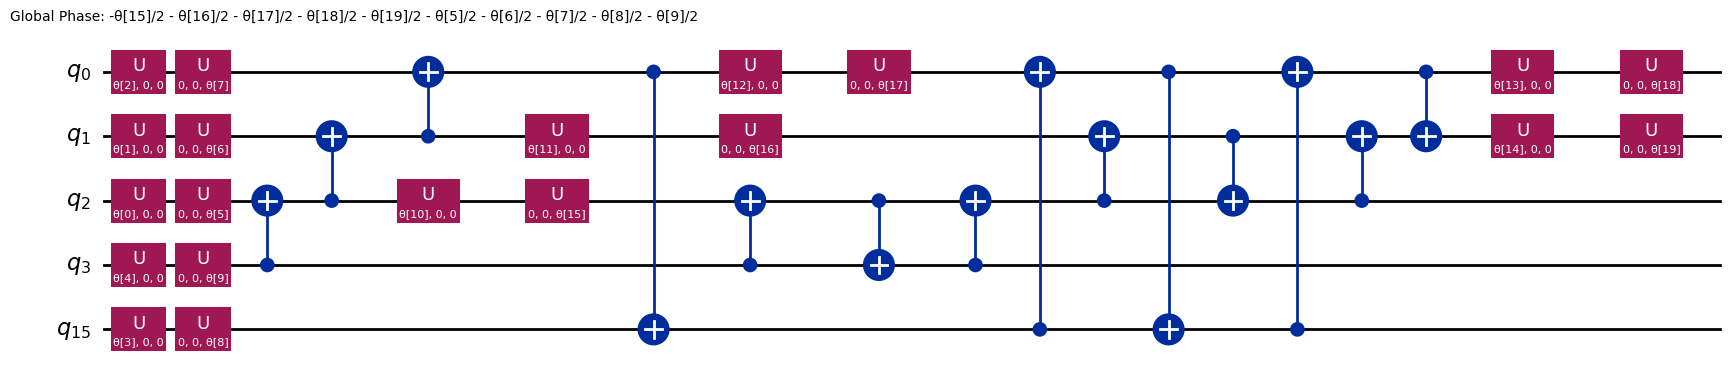

AI transpilation


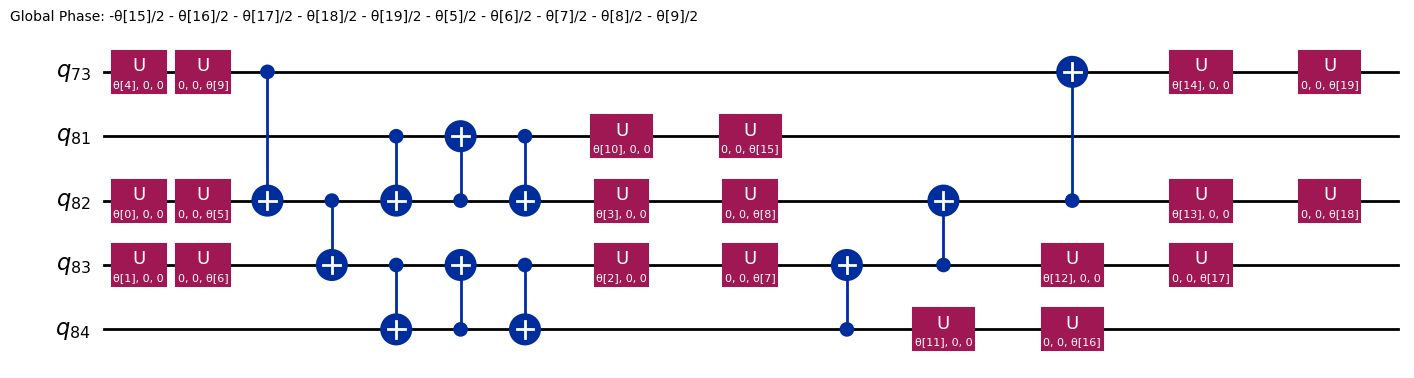

In [11]:
print("Sabre transpilation")
display(tqc_sabre[0].draw("mpl", fold=-1, idle_wires=False))
print("AI transpilation")
display(tqc_ai[0].draw("mpl", fold=-1, idle_wires=False))

Results table.

In [12]:
summary_su2 = (
    results_su2.groupby("method")[["depth", "size", "runtime"]].mean().round(2)
)
print(summary_su2)

results_su2

          depth    size  runtime
method                          
ai_local  56.05  278.10     9.64
sabre     68.45  283.65    16.59


,method,qc_name,qc_index,num_qubits,ops,depth,size,runtime
0,sabre,SU2_5,0,5,"{'u': 20, 'cx': 14}",9,34,0.014092
1,sabre,SU2_10,1,10,"{'u': 40, 'cx': 16}",13,56,0.016636
2,sabre,SU2_15,2,15,"{'u': 60, 'cx': 24}",24,84,0.021532
3,sabre,SU2_20,3,20,"{'u': 80, 'cx': 20}",20,100,0.039370
4,sabre,SU2_25,4,25,"{'u': 100, 'cx': 73}",70,173,0.146291
5,sabre,SU2_30,5,30,"{'u': 120, 'cx': 90}",72,210,2.202554
6,sabre,SU2_35,6,35,"{'u': 140, 'cx': 86}",71,226,16.008190
7,sabre,SU2_40,7,40,"{'u': 160, 'cx': 40}",40,200,2.781399
8,sabre,SU2_45,8,45,"{'u': 180, 'cx': 90}",78,270,17.731576
9,sabre,SU2_50,9,50,"{'u': 200, 'cx': 86}",77,286,20.332638


Results graph.

As we define a function to consistently capture metrics, we will also define one to graph the metrics. Here, we will plot the 2-qubit depth, gate count, and runtime for each compilation method across the circuits.

In [25]:
def plot_transpilation_metrics(results, overall_title, x_axis="qc_index"):
    """
    Plots transpilation metrics (depth, size, runtime) for different transpilation methods.

    Parameters:
        results (DataFrame): Data containing columns ['num_qubits', 'method', 'depth', 'size', 'runtime']
        overall_title (str): The title of the overall figure.
        x_axis (str): The x-axis label, either 'num_qubits' or 'qc_index'.
    """

    fig, axs = plt.subplots(1, 3, figsize=(24, 6))
    metrics = ["depth", "size", "runtime"]
    titles = ["Circuit Depth", "Circuit Size", "Transpilation Runtime"]
    y_labels = ["Depth", "Size (Gate Count)", "Runtime (s)"]

    methods = results["method"].unique()
    colors = plt.cm.get_cmap("tab10", len(methods))
    markers = ["o", "^", "s", "D", "P", "*", "X", "v"]

    color_map = {method: colors(i) for i, method in enumerate(methods)}
    marker_map = {method: markers[i % len(markers)] for i, method in enumerate(methods)}
    jitter_factor = 0.1  # Small x-axis jitter for visibility
    handles, labels = [], []  # Unique handles for legend

    # Plot each metric
    for i, metric in enumerate(metrics):
        for method in methods:
            method_data = results[results["method"] == method]

            # Introduce slight jitter to avoid exact overlap
            jitter = np.random.uniform(-jitter_factor, jitter_factor, len(method_data))

            scatter = axs[i].scatter(
                method_data[x_axis] + jitter,
                method_data[metric],
                color=color_map[method],
                label=method,
                marker=marker_map[method],
                alpha=0.7,
                edgecolors="black",
                s=80,
            )

            if method not in labels:
                handles.append(scatter)
                labels.append(method)

        axs[i].set_title(titles[i])
        axs[i].set_xlabel(x_axis)
        axs[i].set_ylabel(y_labels[i])
        axs[i].grid(axis="y", linestyle="--", alpha=0.7)
        axs[i].tick_params(axis="x", rotation=45)
        axs[i].set_xticks(sorted(results[x_axis].unique()))

    fig.suptitle(overall_title, fontsize=16)
    fig.legend(
        handles=handles, labels=labels, loc="upper right", bbox_to_anchor=(1.05, 1)
    )

    plt.tight_layout()
    plt.show()

/var/folders/jt/44gl1rhd26v6ykt0frqzl87r0000gn/T/ipykernel_59246/1325294152.py:17: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  colors = plt.cm.get_cmap("tab10", len(methods))


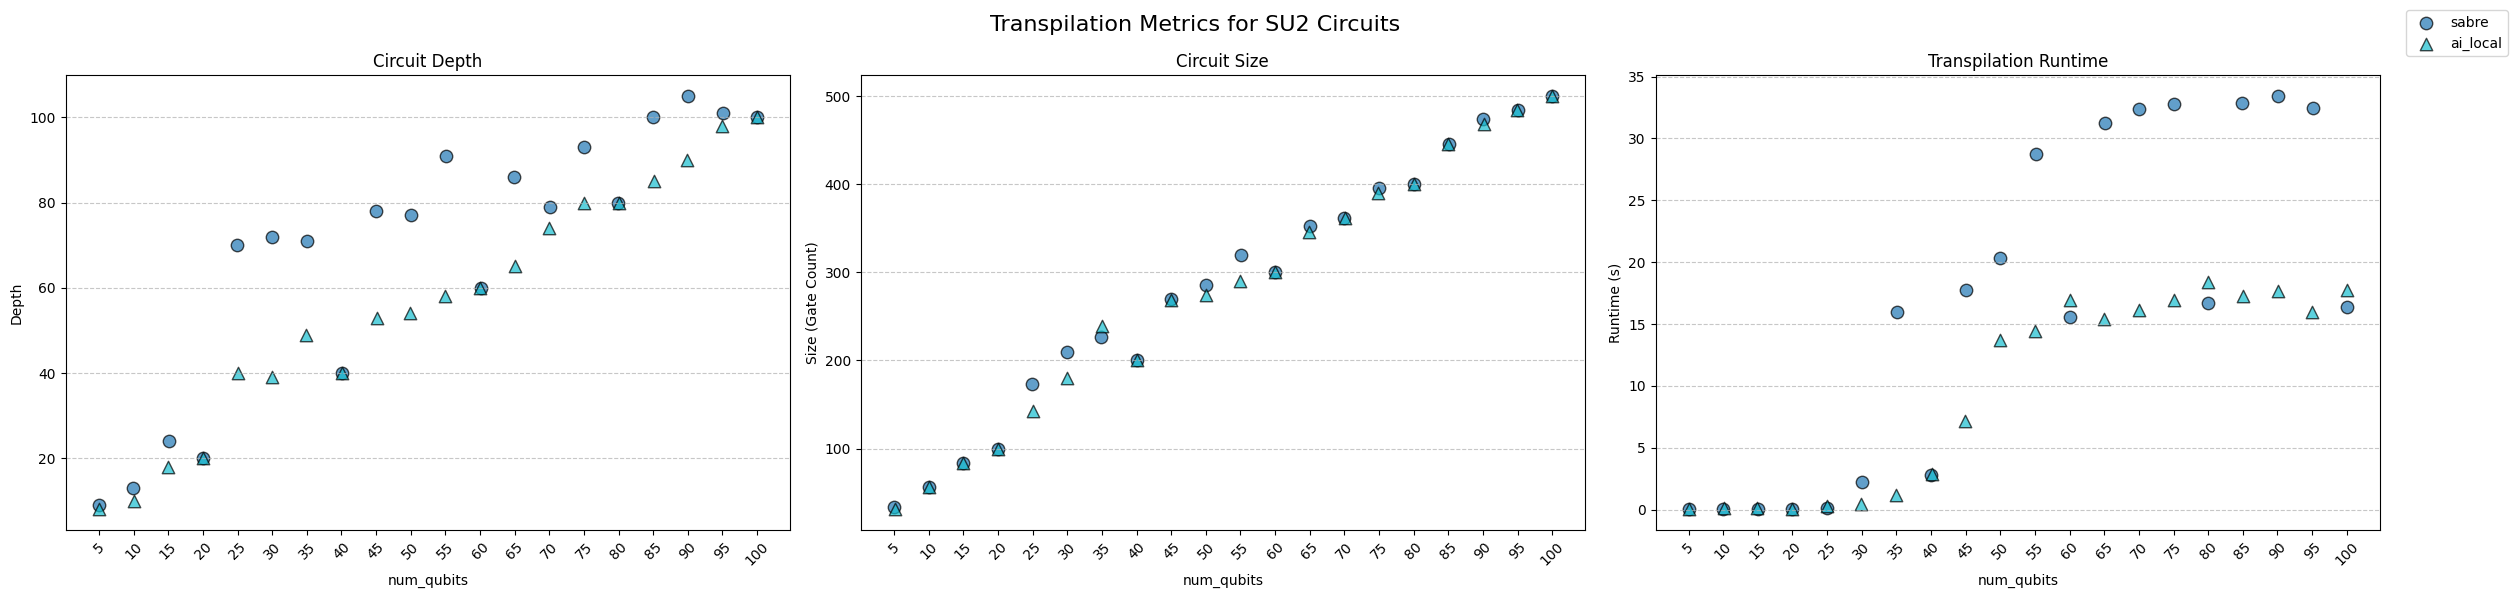

In [26]:
plot_transpilation_metrics(
    results_su2, "Transpilation Metrics for SU2 Circuits", x_axis="num_qubits"
)

### Analysis of SU2 Circuit Compilation Results

In this experiment, we compare two transpilation methods—Qiskit's SABRE transpiler and the AI-powered transpiler—on a set of `EfficientSU2` circuits. Since these circuits do not include any `PauliEvolutionGate` operations, the Rustiq plugin is not included in this comparison.

The AI transpiler performs better than SABRE across all three metrics:
- It produces shallower circuits, with an average depth improvement of over 17%.
- It results in a slightly smaller gate count, indicating more compact circuit representations.
- It also reduces transpilation runtime by approximately 42 percent, making it more efficient as circuit size grows.

From the graph:
- In the Circuit Depth plot, SABRE shows a noticeable increase in depth beginning around 20 qubits, followed by a steady linear trend. The AI transpiler maintains a more stable depth as the number of qubits increases, suggesting more effective layout and routing solutions.
- In the Transpilation Runtime plot, SABRE's runtime increases sharply with qubit count, while the AI transpiler shows a more gradual and steady scaling behavior.

Overall, for variational circuits like `EfficientSU2`, the AI transpiler offers clear advantages in both circuit quality and compilation efficiency compared to SABRE.

# Part 2: Hamiltonian Simulation Circuit

## Step 1: Investigating Circuits with `PauliEvolutionGate`

In this section, we investigate **quantum circuits constructed using `PauliEvolutionGate`**, which enables efficient simulation of Hamiltonians. We will analyze how different compilation methods optimize these circuits across various Hamiltonians.

### Hamiltonians Used in the Benchmark

The Hamiltonians used in this benchmark describe **pairwise interactions between qubits**, including terms such as $ZZ$, $XX$, and $YY$. These Hamiltonians are commonly used in **quantum chemistry, condensed matter physics, and materials science**, where they model systems of interacting particles.

For reference, users can explore a broader set of Hamiltonians in this paper: [**Efficient Hamiltonian Simulation on Noisy Quantum Devices**](https://arxiv.org/pdf/2306.13126).

### Benchmark Source: Hamlib and Benchpress

The circuits benchmarked here are sourced from the **Hamlib benchmark repository**, specifically from: [**Hamlib Benchmark Repo**](https://github.com/SRI-International/QC-App-Oriented-Benchmarks/tree/master/hamlib).

For our benchmarking, we use the **same Hamlib circuits previously benchmarked in** [**Benchpress**](https://github.com/Qiskit/benchpress), an open-source tool for benchmarking quantum software. Benchpress provides a **standardized approach** to evaluating transpilation performance across various quantum circuit families.

Hamiltonian simulation is a foundational task in quantum computing, with applications in **molecular simulations, optimization problems, and quantum many-body physics**. Understanding how different compilation methods optimize these circuits helps improve their practical execution on near-term quantum devices.

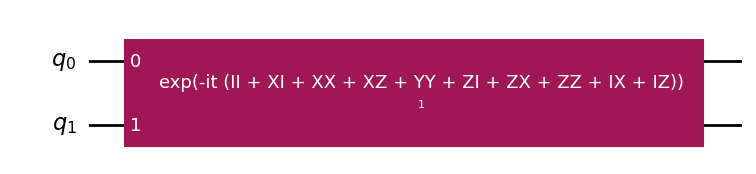

In [15]:
# Obtain the hamiltonian circuits from the json file
json_file = "100_representative.json"
ham_records = json.load(open(json_file))
# Remove circuits that are too large for the backend
ham_records = [h for h in ham_records if h["ham_qubits"] <= backend.num_qubits]
# Remove circuits that are too large for faster benchmarking set
ham_records = [h for h in ham_records if h["ham_terms"] < 300]

qc_ham_list = []
for h in ham_records:
    terms = h["ham_hamlib_hamiltonian_terms"]
    coeff = h["ham_hamlib_hamiltonian_coefficients"]
    num_qubits = h["ham_qubits"]
    name = h["ham_problem"]

    evo_gate = PauliEvolutionGate(SparsePauliOp(terms, coeff))

    qc_ham = QuantumCircuit(num_qubits)
    qc_ham.name = name

    qc_ham.append(evo_gate, range(num_qubits))
    qc_ham_list.append(qc_ham)

# Draw the first Hamiltonian circuit
qc_ham_list[0].draw("mpl", fold=-1)

## Step 2: Optimize Problem for Quantum Hardware Execution

As in the previous example, we will use the same backend to ensure consistency in our comparisons. Since the pass managers (`pm_sabre`, `pm_ai`, and `pm_rustiq`) have already been initialized, we can directly proceed with transpiling the Hamiltonian circuits using each method.

This step focuses solely on performing the transpilation and recording the resulting circuit metrics, including depth, gate count, and transpilation runtime. By analyzing these results, we aim to determine the efficiency of each transpilation method for this type of circuit.

Transpile and capture metrics.

In [16]:
results_ham = pd.DataFrame(
    columns=[
        "method",
        "qc_name",
        "qc_index",
        "num_qubits",
        "ops",
        "depth",
        "size",
        "runtime",
    ]
)

tqc_sabre = capture_transpilation_metrics(results_ham, pm_sabre, qc_ham_list, "sabre")
tqc_ai = capture_transpilation_metrics(results_ham, pm_ai, qc_ham_list, "ai_local")
tqc_ai_pauli = capture_transpilation_metrics(
    results_ham, pm_ai_pauli, qc_ham_list, "ai_pauli"
)
tqc_rustiq = capture_transpilation_metrics(
    results_ham, pm_rustiq, qc_ham_list, "rustiq"
)

Transpiled circuit index 0 (all-vib-bh) in 0.01 seconds with method sabre, depth 3, and size 11.
Transpiled circuit index 1 (all-vib-c2h) in 0.01 seconds with method sabre, depth 18, and size 54.
Transpiled circuit index 2 (all-vib-o3) in 0.01 seconds with method sabre, depth 6, and size 22.
Transpiled circuit index 3 (all-vib-c2h) in 0.18 seconds with method sabre, depth 2, and size 16.
Transpiled circuit index 4 (graph-gnp_k-2) in 0.01 seconds with method sabre, depth 24, and size 53.
Transpiled circuit index 5 (LiH) in 0.02 seconds with method sabre, depth 67, and size 134.
Transpiled circuit index 6 (all-vib-fccf) in 0.02 seconds with method sabre, depth 67, and size 154.
Transpiled circuit index 7 (all-vib-ch2) in 0.02 seconds with method sabre, depth 87, and size 194.
Transpiled circuit index 8 (all-vib-f2) in 0.04 seconds with method sabre, depth 215, and size 494.
Transpiled circuit index 9 (all-vib-bhf2) in 0.39 seconds with method sabre, depth 22, and size 107.
Transpiled cir

Results table (skipping visualization as the output circuits are very large).

In [17]:
summary_ham = (
    results_ham.groupby("method")[["depth", "size", "runtime"]].mean().round(2)
)
print(summary_ham)

results_ham

           depth    size  runtime
method                           
ai_local  334.36  920.00     0.90
ai_pauli  325.11  902.42     9.19
rustiq    291.36  897.89     0.30
sabre     354.83  910.61     0.29


,method,qc_name,qc_index,num_qubits,ops,depth,size,runtime
0,sabre,all-vib-bh,0,2,"{'u': 8, 'cx': 3}",3,11,0.008774
1,sabre,all-vib-c2h,1,3,"{'u': 36, 'cx': 18}",18,54,0.013026
2,sabre,all-vib-o3,2,4,"{'u': 16, 'cx': 6}",6,22,0.005712
3,sabre,all-vib-c2h,3,4,"{'u': 12, 'cx': 4}",2,16,0.181885
4,sabre,graph-gnp_k-2,4,4,"{'u': 29, 'cx': 24}",24,53,0.013874
...,...,...,...,...,...,...,...,...
139,rustiq,uf100-ham,31,46,"{'cx': 3032, 'u': 598}",1015,3630,0.248281
140,rustiq,uf100-ham,32,46,"{'cx': 2786, 'u': 625}",899,3411,0.230274
141,rustiq,all-vib-cyclo_propene,33,64,"{'cx': 538, 'u': 455}",67,993,3.040059
142,rustiq,tfim,34,75,"{'cx': 1600, 'u': 476}",370,2076,0.157312


Results graph.

Visualize performance based on circuit index.

/var/folders/jt/44gl1rhd26v6ykt0frqzl87r0000gn/T/ipykernel_59246/1325294152.py:17: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  colors = plt.cm.get_cmap("tab10", len(methods))


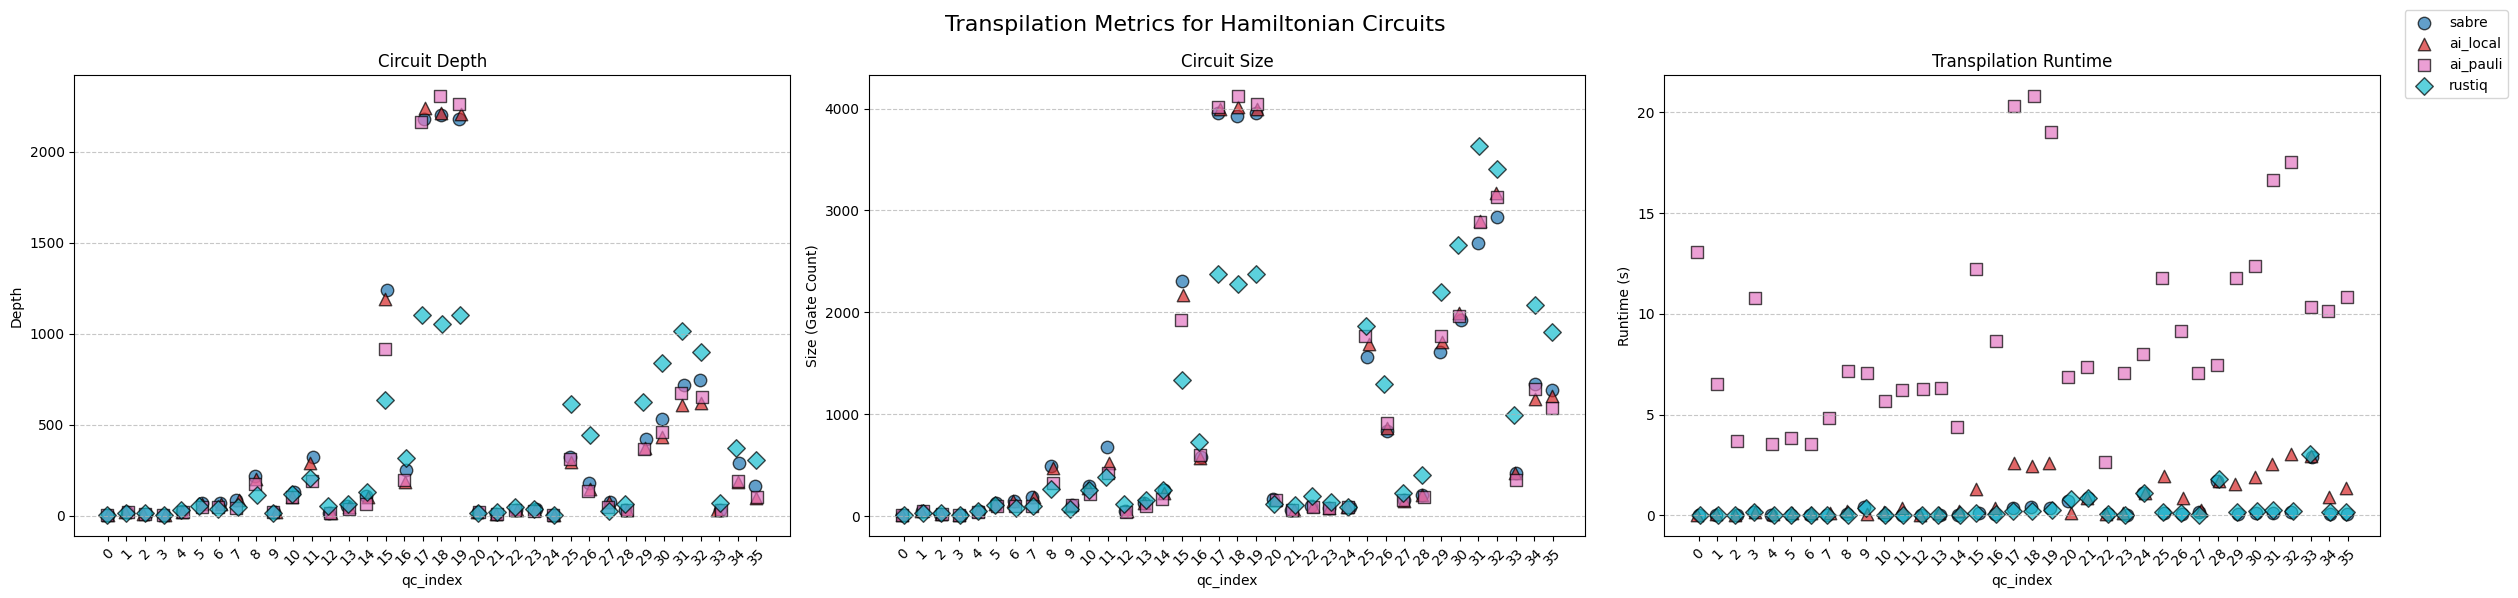

In [27]:
plot_transpilation_metrics(
    results_ham, "Transpilation Metrics for Hamiltonian Circuits"
)

Visualize the percentage of circuits for which each method performed best.

Best-performing methods based on depth:
    ai_pauli: 19 circuit(s)
    ai_local: 14 circuit(s)
    rustiq: 13 circuit(s)
    sabre: 6 circuit(s)


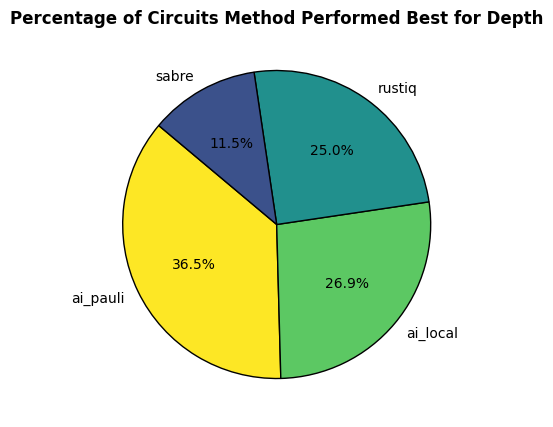

Best-performing methods based on size:
    ai_pauli: 14 circuit(s)
    rustiq: 14 circuit(s)
    sabre: 8 circuit(s)
    ai_local: 6 circuit(s)


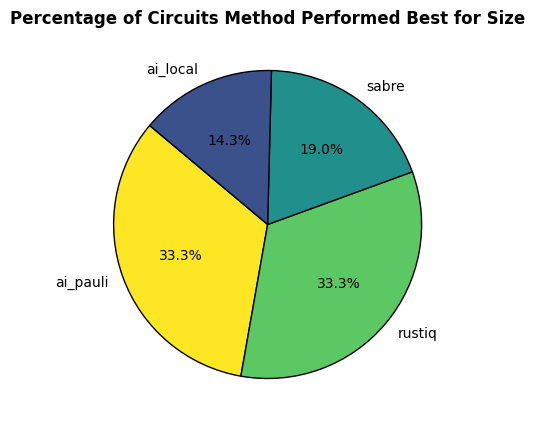

In [31]:
def analyze_and_plot_best_methods(results, metric):
    """
    Analyze the best-performing methods for a given metric and plot a pie chart.

    Parameters:
        results (DataFrame): The input DataFrame containing method performance data.
        metric (str): The metric to evaluate ("depth" or "size").
    """
    method_counts = Counter()
    for qc_idx, group in results.groupby("qc_index"):
        min_value = group[metric].min()

        # Find all methods that achieved this minimum value
        best_methods = group[group[metric] == min_value]["method"]
        # Update counts for all best methods (handling ties)
        method_counts.update(best_methods)
    best_method_counts = dict(
        sorted(method_counts.items(), key=lambda x: x[1], reverse=True)
    )

    # Print summary
    print(f"Best-performing methods based on {metric}:")
    for method, count in best_method_counts.items():
        print(f"    {method}: {count} circuit(s)")

    # Plot pie chart
    num_methods = len(best_method_counts)
    colors = plt.cm.viridis_r(range(0, 256, 256 // num_methods))
    plt.figure(figsize=(5, 5))
    plt.pie(
        best_method_counts.values(),
        labels=best_method_counts.keys(),
        autopct="%1.1f%%",
        startangle=140,
        wedgeprops={"edgecolor": "black"},
        textprops={"fontsize": 10},
        colors=colors,
    )
    plt.title(
        f"Percentage of Circuits Method Performed Best for {metric.capitalize()}",
        fontsize=12,
        fontweight="bold",
    )
    plt.show()


analyze_and_plot_best_methods(results_ham, "depth")
analyze_and_plot_best_methods(results_ham, "size")

### Analysis of Hamiltonian Circuit Compilation Results

In this section, we evaluate the performance of four transpilation methods—SABRE, AI Local, AI Pauli, and Rustiq—on quantum circuits constructed with `PauliEvolutionGate`, which are commonly used for Hamiltonian simulation tasks.

Rustiq performed best on average in terms of depth and size, and matched SABRE in runtime performance. This result is expected, since Rustiq was specifically designed to synthesize circuits with `PauliEvolutionGate` operations using precise and low-depth methods.

The AI Pauli method also showed strong performance. Compared to AI Local, it achieved lower depth and size across circuits. However, its runtime was significantly higher, as the AI Pauli transpiler does not currently run locally. A future update will enable local execution, which may reduce the runtime substantially.

From the graphs:
- The depth and size scatter plots show that Rustiq and AI Pauli frequently generate more compact circuits.
- The pie charts show that AI Pauli performed best for the largest percentage of circuits in terms of both depth and size.
- Despite this, Rustiq still had the lowest average depth and gate count.

Each Hamiltonian circuit in this experiment differs significantly in structure, and this is reflected in the varying performance of the methods. The best-performing method depends on the circuit being compiled. Although Rustiq performed best on average, the results suggest that no single method dominates across all Hamiltonian circuits. We recommend users test multiple transpilation methods—particularly Rustiq and AI Pauli—to determine which produces the most efficient circuit for their specific use case.

## Step 3: Execute using Qiskit primitives

As this tutorial focuses on transpilation, no experiments will be executed on the quantum device. The goal is to leverage the optimizations from Step 2 to obtain a transpiled circuit with reduced depth and/or gate count.

## Step 4: Post-process and return result in desired classical format

Since there is no execution for this notebook, there are no results to post-process.

## References
[1] "LightSABRE: A Lightweight and Enhanced SABRE Algorithm". H. Zou, M. Treinish, K. Hartman, A. Ivrii, J. Lishman et al. https://arxiv.org/abs/2409.08368

[2] "Practical and efficient quantum circuit synthesis and transpiling with Reinforcement Learning". D. Kremer, V. Villar, H. Paik, I. Duran, I. Faro, J. Cruz-Benito et al. https://arxiv.org/abs/2405.13196

[3] "Pauli Network Circuit Synthesis with Reinforcement Learning". A. Dubal,  D. Kremer, S. Martiel, V. Villar, D. Wang, J. Cruz-Benito et al. https://arxiv.org/abs/2503.14448

[4] "Faster and shorter synthesis of Hamiltonian simulation circuits". T. Goubault de Brugière, S. Martiel et al. https://arxiv.org/abs/2404.03280